# Multivariate Gaussian Sampling Demo (Example 3.4)

This notebook demonstrates drawing samples from a 2D Gaussian using the linear transform approach: draw $Z \sim \mathcal{N}(0, I)$ and set $X = \mu + L Z$, where $\Sigma = L L^T$ (Cholesky factor).

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

from mc_lab.multivariate_gaussian import sample_multivariate_gaussian

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)

## Draw samples and inspect sample statistics
We'll target a 2D Gaussian with mean $\mu=[1, -2]$ and covariance
$\Sigma=\begin{bmatrix}2 & 1.2\\ 1.2 & 1.5\end{bmatrix}$.

In [9]:
# Parameters
mu = np.array([1.0, -2.0])
Sigma = np.array([[2.0, 1.2], [1.2, 1.5]])
n = 5000
seed = 42

# Sample
X = sample_multivariate_gaussian(mu, Sigma, n, random_state=seed)

# Sample mean and covariance
m_hat = X.mean(axis=0)
S_hat = np.cov(X, rowvar=False, bias=False)

print("Sample mean:     ", m_hat)
print("Target mean:     ", mu)
print()
print("Sample covariance:", S_hat)
print("Target covariance:", Sigma)

Sample mean:      [ 0.98625633 -2.01776817]
Target mean:      [ 1. -2.]

Sample covariance: [[1.95740785 1.19623222]
 [1.19623222 1.54741157]]
Target covariance: [[2.  1.2]
 [1.2 1.5]]


## Visualize samples with covariance ellipse
We overlay the 2-standard-deviation covariance ellipse computed from $\Sigma$.

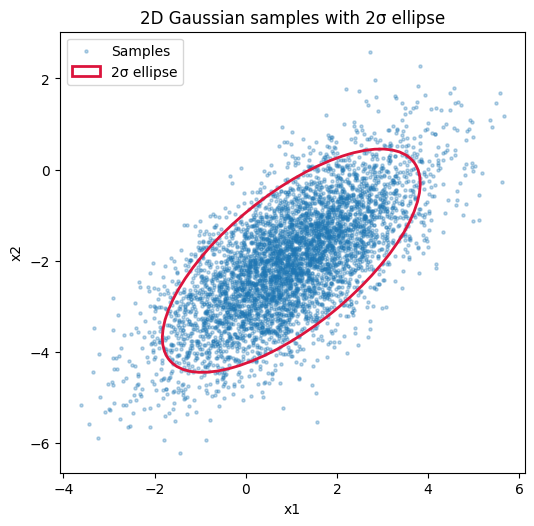

In [6]:
def plot_cov_ellipse(ax, mean, cov, nsig=2.0, **kwargs):
    # Eigen-decomposition
    vals, vecs = np.linalg.eigh(cov)
    # Sort descending
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]
    # Width/height are 2*sqrt(lambda) scaled by nsig
    width, height = 2 * nsig * np.sqrt(vals)
    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    from matplotlib.patches import Ellipse

    ell = Ellipse(
        xy=mean, width=width, height=height, angle=angle, fill=False, **kwargs
    )
    ax.add_patch(ell)
    return ell


fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, alpha=0.3, label="Samples")
plot_cov_ellipse(ax, mu, Sigma, nsig=2.0, color="crimson", lw=2, label="2σ ellipse")
ax.set_aspect("equal", adjustable="box")
ax.set_title("2D Gaussian samples with 2σ ellipse")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.show()

### Note on robustness
The sampler uses Cholesky when possible, and automatically falls back to an eigen-decomposition with clipped non-negative eigenvalues if the covariance is only positive semi-definite.

## Reproducibility with numpy.random.Generator
The sampler accepts either an integer seed or a `numpy.random.Generator` instance for reproducibility.

Using a `Generator` lets you manage independent streams, control bit generators, and pass the same RNG to multiple functions. Below we use a `Generator` and show that repeated calls with the same generator state produce deterministic results; resetting the generator to the same seed reproduces the same samples.

In [ ]:
# Using numpy.random.Generator for reproducibility
import numpy as np

from mc_lab.multivariate_gaussian import sample_multivariate_gaussian

mu_demo = np.array([0.0, 0.0])
Sigma_demo = np.array([[1.0, 0.8], [0.8, 2.0]])

# Create a Generator with a fixed seed
rng = np.random.default_rng(12345)

# Draw samples using the Generator
X1 = sample_multivariate_gaussian(mu_demo, Sigma_demo, 5, random_state=rng)
X2 = sample_multivariate_gaussian(mu_demo, Sigma_demo, 5, random_state=rng)

print("First batch:\n", X1)
print("Second batch (same stream):\n", X2)

# Reset generator to the same seed to reproduce the same first batch
rng = np.random.default_rng(12345)
X1_repeat = sample_multivariate_gaussian(mu_demo, Sigma_demo, 5, random_state=rng)
print("\nRepeat first batch after re-seeding:\n", X1_repeat)

# Assert equality to confirm reproducibility
assert np.allclose(X1, X1_repeat)

First batch:
 [[-1.42382504  0.33468794]
 [-0.87066174 -0.99877472]
 [-0.07534331 -0.9242872 ]
 [-1.3677927  -0.33750162]
 [ 0.36105811 -1.98856363]]
Second batch (same stream):
 [[ 2.34740965  3.0073795 ]
 [-0.75938718  0.4446252 ]
 [-0.46695317 -0.44433807]
 [ 0.78884434 -0.83443881]
 [ 0.57585751  2.09216186]]

Repeat first batch after re-seeding:
 [[-1.42382504  0.33468794]
 [-0.87066174 -0.99877472]
 [-0.07534331 -0.9242872 ]
 [-1.3677927  -0.33750162]
 [ 0.36105811 -1.98856363]]


## Seed vs Generator: what's the difference?
- Integer seed (e.g., `random_state=42`) tells the sampler to create a new RNG with that seed for that call. Each call with the same seed restarts the sequence from the beginning, which is handy for isolated, reproducible snippets but can accidentally couple randomness across functions if all use the same fixed seed internally.
- A `numpy.random.Generator` carries state. Passing the same `Generator` across calls advances a single stream, ensuring independent draws across functions without repeating the same first numbers. If you want to reproduce results, re-seed or re-create the `Generator` with the same seed and re-run.

In short:
- Use integer seeds for quick, self-contained reproducibility.
- Use a shared `Generator` when coordinating randomness across multiple calls/modules or when you want independent, contiguous draws from one stream.

In [ ]:
# Contrast: repeated integer seed vs shared Generator
import numpy as np

from mc_lab.multivariate_gaussian import sample_multivariate_gaussian

mu_c = np.array([0.0, 0.0])
Sigma_c = np.array([[1.0, 0.5], [0.5, 1.0]])

# Using the same integer seed for each call restarts the sequence
X_a1 = sample_multivariate_gaussian(mu_c, Sigma_c, 3, random_state=42)
X_a2 = sample_multivariate_gaussian(mu_c, Sigma_c, 3, random_state=42)
print("Integer seed 42 twice -> identical batches?", np.allclose(X_a1, X_a2))

# Using a shared Generator advances the stream across calls
rng_c = np.random.default_rng(42)
X_b1 = sample_multivariate_gaussian(mu_c, Sigma_c, 3, random_state=rng_c)
X_b2 = sample_multivariate_gaussian(mu_c, Sigma_c, 3, random_state=rng_c)
print("Shared Generator -> different batches?", not np.allclose(X_b1, X_b2))

# Re-seed to reproduce the first batch
rng_c = np.random.default_rng(42)
X_b1_repeat = sample_multivariate_gaussian(mu_c, Sigma_c, 3, random_state=rng_c)
print("Re-seeded Generator reproduces first batch?", np.allclose(X_b1, X_b1_repeat))

Integer seed 42 twice -> identical batches? True
Shared Generator -> different batches? True
Re-seeded Generator reproduces first batch? True
